In [1]:
from pdb import run
from fff.simulation import run_calculator
from fff.simulation.utils import read_from_string, write_to_string
from _pytest.fixtures import fixture
import ase
from ase.build import molecule
from dataclasses import dataclass
from pathlib import Path
from typing  import Dict, Any, List, Optional
import os
import psutil
from functools import partial, update_wrapper
import json
import pickle
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
## data structures classes
@dataclass
class Trajectory:
    """Tracks the state of searching along individual trajectories

    We mark the starting point, the last point produced from sampling,
    and the last point we produced that has been validated
    """
    id: int  # ID number of the
    starting: ase.Atoms  # Starting point of the trajectory
    current_timestep = 0  # How many timesteps have been used so far
    last_validated: ase.Atoms = None  # Last validated point on the trajectory
    current: ase.Atoms = None  # Last point produced along the trajectory
    last_run_length: int = 0  # How long between current and last_validated
    name: str = None  # Name of the trajectory

    def __post_init__(self):
        self.last_validated = self.current = self.starting

    def update_current_structure(self, strc: ase.Atoms, run_length: int):
        """Update the structure that has yet to be updated

        Args:
            strc: Structure produced by sampling
            run_length: How many timesteps were performed in sampling run
        """
        self.current = strc.copy()
        self.last_run_length = run_length

    def set_validation(self, success: bool):
        """Set whether the trajectory was successfully validated

        Args:
            success: Whether the validation was successful
        """
        if success:
            self.last_validated = self.current  # Move the last validated forward
            self.current_timestep += self.last_run_length

@dataclass
class SimulationTask:
    atoms: ase.Atoms  # Structure to be run
    traj_id: int  # Which trajectory this came from
    ml_eng: float  # Energy predicted from machine learning model
    ml_std: Optional[float] = None  # Uncertainty of the model
    
@dataclass
class my_SimulationTask:
    simu_task: SimulationTask # basic information store in SimulationTask
    dft_energy: Optional[float] = None  # DFT energy of the structure
    dft_time: Optional[dict[int,float]] = None  # Dictionary to store DFT run times for different CPU cores

In [3]:
current_path = os.path.dirname(os.path.abspath("__file__"))
out_dir = Path(current_path) / 'non_linear_temp'
with open(out_dir / 'task_queue_simulated', 'rb') as f:
    task_queue_simulated = pickle.load(f)
    


[(12, 5.850254774093628), (15, 7.936183929443359), (18, 14.705122470855713), (21, 16.75410395860672), (24, 21.41688847541809), (27, 24.086347818374634), (30, 31.15443527698517), (33, 40.727830992804634), (36, 48.143983125686646), (39, 59.534986893335976), (42, 72.19054274559021), (45, 83.08321416378021), (48, 97.04547603925069), (51, 107.61373349598476), (54, 133.2091362476349), (57, 133.03949835896492), (60, 174.3393987417221), (63, 203.84687733650208), (66, 245.14138960838318), (69, 267.0610399246216), (72, 330.6697278022766), (75, 359.20263490080833)]


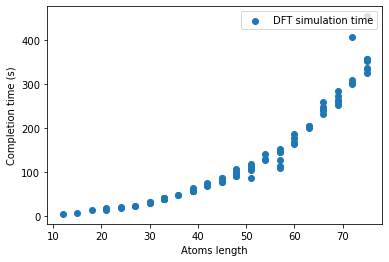

In [16]:
## plot the distribution of the simulation time with respect to the atoms length
atoms_length = []
simulation_time = []
for task in task_queue_simulated:
    atoms_length.append(len(task.simu_task.atoms))
    simulation_time.append(task.dft_time[64])
    
plt.scatter(atoms_length, simulation_time,label='DFT simulation time')
plt.xlabel('Atoms length')
plt.ylabel('Completion time (s)')
plt.legend(loc='upper right')

## sort and print average time for each atoms length
# 创建一个空字典来存储不同长度对应的运行时间和计数
time_dict = {}

# 遍历分子长度和对应的运行时间
for atom, t in zip(atoms_length, simulation_time):
    if atom in time_dict:
        # 如果分子长度已存在于字典中，累加运行时间和计数
        time_dict[atom][0] += t
        time_dict[atom][1] += 1
    else:
        # 如果分子长度不存在于字典中，初始化运行时间和计数
        time_dict[atom] = [t, 1]

# 打印每个长度的平均运行时间
# for atom, values in sorted(time_dict.items()):
    # avg_time = values[0] / values[1]
    # print(f"Length {atom}: Average Time = {avg_time}")
result_dict = {atom: values[0] / values[1] for atom, values in time_dict.items()}
result_dict = sorted(result_dict.items(), key=lambda x: x[0])
print(result_dict)
## sorted dict

##save result_dict
with open(out_dir / 'length_time', 'wb') as f:
    pickle.dump(result_dict, f)

[1, 2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]
[459.49200105667114, 308.5443150997162, 178.95574569702148, 114.76378226280212, 88.14041328430176, 76.19267272949219, 68.74859023094177, 64.68302941322327, 63.44424271583557, 66.51880431175232, 69.2843005657196, 70.93301844596863, 69.64240193367004, 70.88759207725525, 69.63654398918152, 71.50614309310913, 71.06448984146118, 72.96044158935547]
{1: 459.49200105667114, 2: 308.5443150997162, 4: 178.95574569702148, 8: 114.76378226280212, 12: 88.14041328430176, 16: 76.19267272949219, 20: 68.74859023094177, 24: 64.68302941322327, 28: 63.44424271583557, 32: 66.51880431175232, 36: 69.2843005657196, 40: 70.93301844596863, 44: 69.64240193367004, 48: 70.88759207725525, 52: 69.63654398918152, 56: 71.50614309310913, 60: 71.06448984146118, 64: 72.96044158935547}


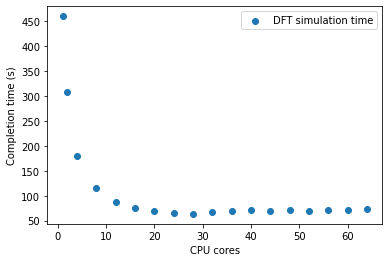

In [12]:
## plot non_linear performance with respect to the cpu cores
with open(out_dir / 'non_linear_task', 'rb') as f:
    task = pickle.load(f)
cpus = []
time = []
sorted_keys = sorted(task.dft_time.keys())
for key in sorted_keys:
    cpus.append(key)
    time.append(task.dft_time[key])                                                 
print(cpus)
print(time)
plt.scatter(cpus, time,label='DFT simulation time')
plt.xlabel('CPU cores')
plt.ylabel('Completion time (s)')
plt.legend(loc='upper right')

## save cpu and time as dict and save
cpu_time_dict = dict(zip(cpus, time))
print(cpu_time_dict)
with open(out_dir / 'cpu_time', 'wb') as f:
    pickle.dump(cpu_time_dict, f)

In [8]:
## use polynomial regression to fit the data and predict the simulation time
params = []
time = []
for task in task_queue_simulated:
    for key,value in task.dft_time.items(): 
        params.append([len(task.simu_task.atoms),key])
        time.append(value)
with open(out_dir / 'non_linear_task', 'rb') as f:
    task = pickle.load(f)
for key,value in task.dft_time.items():
    params.append([len(task.simu_task.atoms),key])
    time.append(value)
    
params = np.array(params)
time = np.array(time)

poly = PolynomialFeatures(degree=4)
X_ = poly.fit_transform(params)
clf = LinearRegression()
clf.fit(X_, time)

cpu = np.arange(1,65)
atoms_length = np.arange(1,100)
run_time = [[0 for i in range(1,100)] for j in range(1,65)]
for c,ci in enumerate(cpu):
    for a,ai in enumerate(atoms_length):
        X = poly.fit_transform([[ai,ci]])
        time = clf.predict(X)
        run_time[ci-1][ai-1]=time[0]
run_time = np.array(run_time)
print(run_time)

[[ 2.69286714e+01  2.69237582e+01  2.69217780e+01 ...  5.76251182e+03
   5.96513214e+03  6.17284494e+03]
 [ 2.68968655e+01  2.69365402e+01  2.69294499e+01 ...  5.45319576e+03
   5.64831492e+03  5.84841844e+03]
 [ 2.67297393e+01  2.68905029e+01  2.69564936e+01 ...  5.15879403e+03
   5.34665073e+03  5.53938539e+03]
 ...
 [-1.33197301e+02 -1.28671989e+02 -1.24082957e+02 ...  1.01097933e+03
   1.05470484e+03  1.10002024e+03]
 [-7.05369560e+01 -6.83269257e+01 -6.59997939e+01 ...  1.00784588e+03
   1.05160589e+03  1.09695076e+03]
 [-1.22048344e+00 -1.48344806e+00 -1.57424065e+00 ...  1.00393362e+03
   1.04773264e+03  1.09311316e+03]]


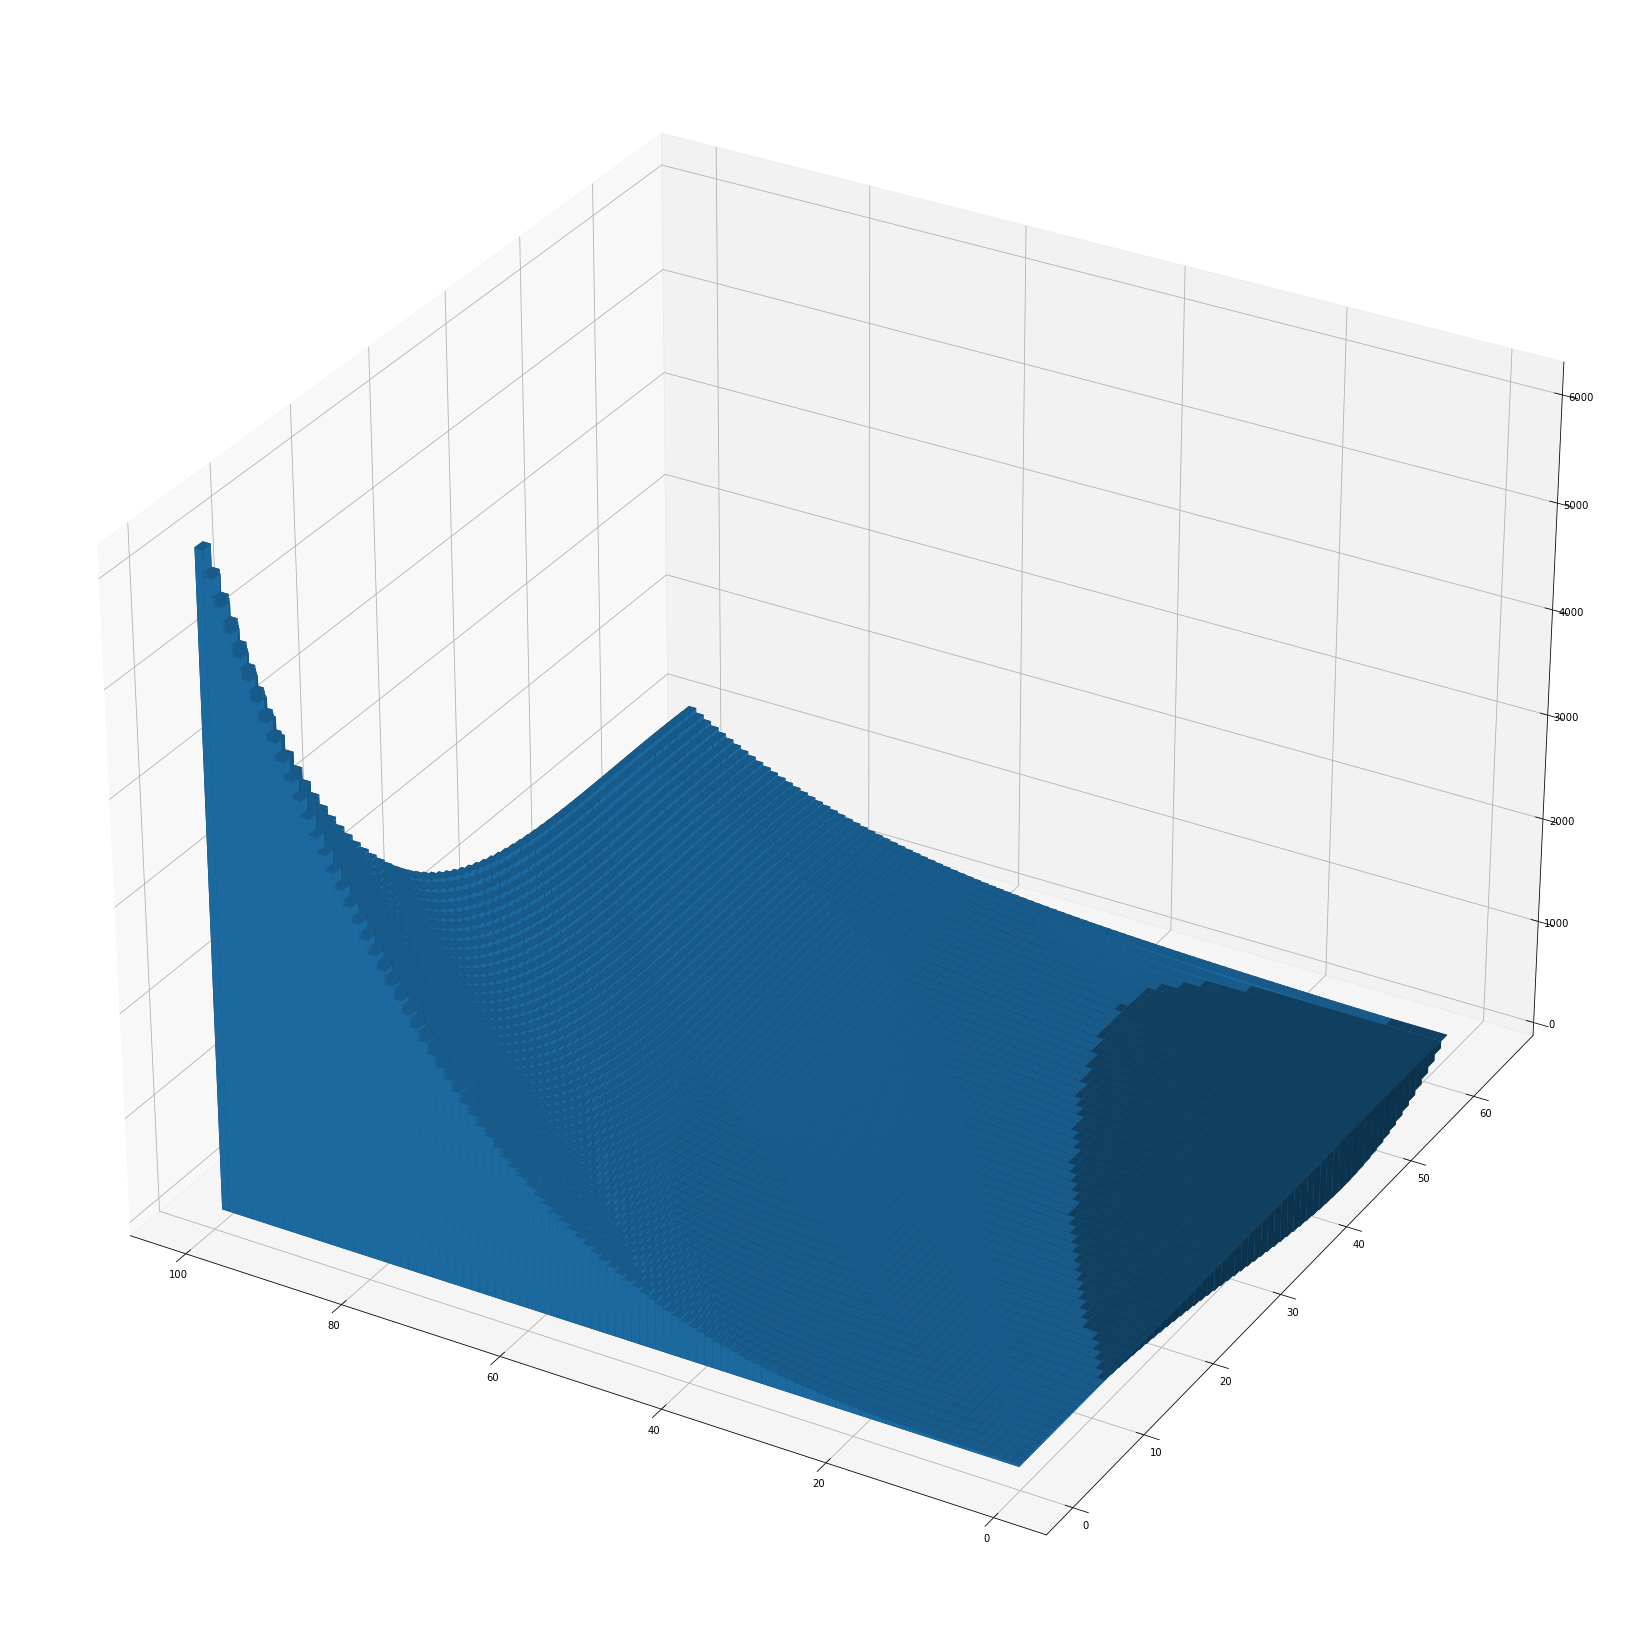

In [104]:
# print(len(run_time))
# print(len(run_time[0]))
# print(len(cpu))


X,Y = np.meshgrid(atoms_length,cpu)
fig = plt.figure(figsize=(40,30))
ax = fig.add_subplot(111,projection='3d')
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(X).ravel(), 1, 1, run_time.ravel())
# 翻转 x 轴和 y 轴
ax.invert_xaxis()
# ax.invert_yaxis()
plt.show()

[1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 6, 7, 7, 11, 12]


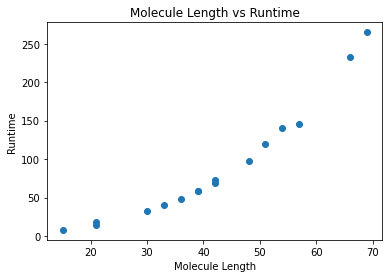

64
15 7.936183929443359
21 13.933068990707397
21 18.53505778312683
30 31.96126937866211
33 39.94735836982727
36 47.87878227233887
39 58.314175605773926
39 58.290982246398926
42 72.97499060630798
42 68.38431143760681
48 97.7802345752716
51 119.92704892158508
54 140.8803994655609
57 145.98701667785645
66 232.69960927963257
69 264.8665609359741


In [27]:
## Simple weighted allocation of resources
task_batch = task_queue_simulated[0:16]
task_batch = sorted(task_batch, key=lambda x: len(x.simu_task.atoms))
molecule_lengths = [len(task.simu_task.atoms) for task in task_batch]
runtimes = [task.dft_time[64] for task in task_batch]

total_time = sum(runtimes)
weights = [math.ceil(runtime / total_time * 64)  for runtime in runtimes]
print(weights)

plt.scatter(molecule_lengths, runtimes)
plt.xlabel('Molecule Length')
plt.ylabel('Runtime')
plt.title('Molecule Length vs Runtime')
plt.show()

cpus = [1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 6, 6, 9, 10]
print(sum(cpus))
for task in task_batch:
    print(len(task.simu_task.atoms), task.dft_time[64])

In [12]:
## find the optimal number of cpu cores for each atoms length task
task_batch = task_queue_simulated[0:16]
task_batch = sorted(task_batch, key=lambda x: len(x.simu_task.atoms))
cpu_cores = [i for i in range(1,65)]

n = len(task_batch)  # number of tasks
m = len(cpu_cores) # number of CPU cores
total_cores = 64  # total number of available CPU cores

# Initialize the dp table.
dp = np.full((n + 1, total_cores + 1), np.inf)
dp[0][0] = 0

# Dynamic programming.
for i in range(1, n + 1):
    for j in range(total_cores + 1):
        for k in range(min(j, m)):
            X = poly.fit_transform([[len(task_batch[i-1].simu_task.atoms),cpu_cores[k]]])
            time = clf.predict(X)
            dp[i][j] = min(dp[i][j], dp[i - 1][j - k] + time)

# Find the minimum total time.
min_total_time = dp[n][total_cores]

print(min_total_time)


inf


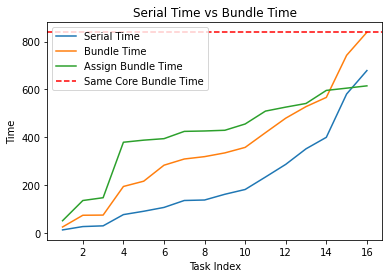

[25.254602909088135, 74.30424785614014, 74.98655343055725, 194.590008020401, 216.61445116996765, 283.46616792678833, 309.3925669193268, 319.2721767425537, 334.9326436519623, 357.91011214256287, 419.40331053733826, 480.05718970298767, 528.3644545078278, 566.8710958957672, 742.7261703014374, 839.1847343444824]
[13, 27, 30, 77, 91, 107, 136, 138, 162, 182, 234, 287, 352, 400, 581, 679]
[51.394065618515015, 135.8691005706787, 147.58229637145996, 379.4496932029724, 388.16188383102417, 394.4132158756256, 424.82830595970154, 426.51030826568604, 429.4793367385864, 455.7351396083832, 509.5767695903778, 526.2569048404694, 541.5261597633362, 596.1085181236267, 605.4730937480927, 615.1164758205414]


In [38]:

# for task in task_queue_simulated:
#     atoms = task.simu_task.atoms
#     print(atoms)
#     print(task.dft_time)

# atoms = task_queue_simulated[2].simu_task.atoms
# print(len(atoms))


serial_time = sorted([182,287,27,400,234,162,581,136,352,77,138,107,679,13,91,30])
bundle_time =[]
assign_bundle_time = []
same_core_bundle_time = 839
# assign_core_bundle_time = 

with open(out_dir / 'task_queue_simulated_4_parrallel', 'rb') as f:
    task_4 = pickle.load(f)
with open(out_dir / 'task_queue_simulated_assign_parrallel', 'rb') as f:
    task_assign = pickle.load(f)
for task in task_4:
    bundle_time.append(task.dft_time[4])
cpus = [2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 8, 9]
cnt = 0
for task in task_assign:
    assign_bundle_time.append(task.dft_time[cpus[cnt]])
    cnt += 1

x = [i for i in range(1,17)]
plt.plot(x, serial_time, label='Serial Time')
plt.plot(x, bundle_time, label='Bundle Time')
plt.plot(x, assign_bundle_time, label='Assign Bundle Time')
plt.axhline(y=same_core_bundle_time, color='r', linestyle='--', label='Same Core Bundle Time')

plt.xlabel('Task Index')
plt.ylabel('Time')
plt.title('Serial Time vs Bundle Time')

plt.legend()

plt.show()
print(bundle_time)
print(serial_time)
print(assign_bundle_time)